In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
# Custom Dataset for Feature Extraction
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, data_dir):
        self.image_paths = image_paths
        self.labels = labels
        self.data_dir = data_dir
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.data_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")
        image = transform(image)
        label = self.labels[idx]
        return image, label


In [5]:
# Load Data
csv_path = "/kaggle/input/us-license-plates-image-classification/new plates/plates.csv"
data_dir = "/kaggle/input/us-license-plates-image-classification/new plates/"
df = pd.read_csv(csv_path)

df_train = df[df["data set"] == "train"][["filepaths", "class id"]]
df_test = df[df["data set"] == "test"][["filepaths", "class id"]]
df_valid = df[df["data set"] == "valid"][["filepaths", "class id"]]

# Create Dataset
train_data = CustomDataset(df_train["filepaths"].values, df_train["class id"].values, data_dir)
test_data = CustomDataset(df_test["filepaths"].values, df_test["class id"].values, data_dir)
valid_data = CustomDataset(df_valid["filepaths"].values, df_valid["class id"].values, data_dir)

# Dataloaders
dl_train = DataLoader(train_data, batch_size=32, shuffle=True)
dl_test = DataLoader(test_data, batch_size=32, shuffle=False)
dl_valid = DataLoader(valid_data, batch_size=32, shuffle=False)

In [6]:
# Load Pretrained ResNet50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove classification layer
resnet = resnet.to(device)
resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:

# Function to Extract Features
def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for images, batch_labels in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            outputs = resnet(images)  # Shape (batch_size, 2048)
            features.append(outputs.cpu().numpy())
            labels.append(batch_labels.numpy())
    return np.vstack(features), np.hstack(labels)

Extracting Features: 100%|██████████| 9/9 [00:01<00:00,  7.57it/s]


Test Accuracy: 0.5286


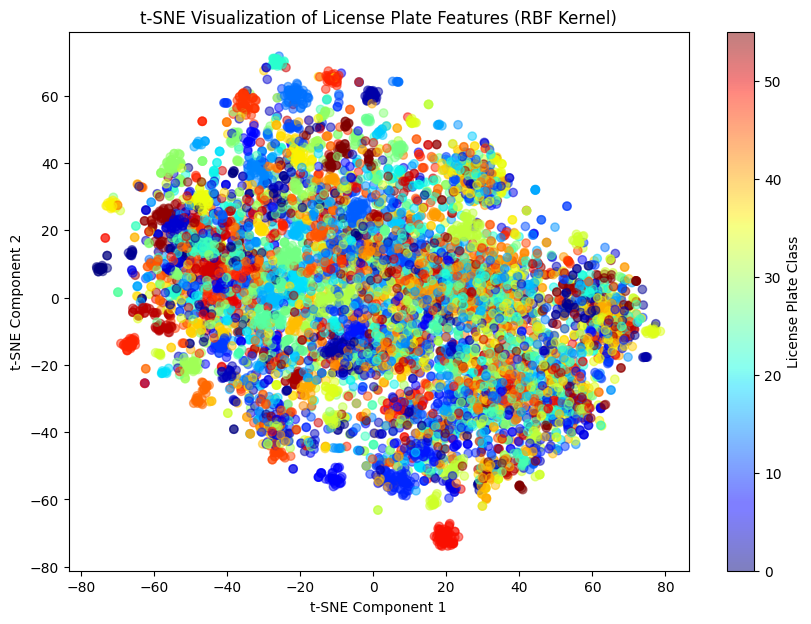

In [10]:
# Extract Features
X_train, y_train = extract_features(dl_train)
X_test, y_test = extract_features(dl_test)
X_valid, y_valid = extract_features(dl_valid)

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

# Train SVM Classifier
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

# Evaluate on Test Set
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Reduce the feature space to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train)  # Apply t-SNE on the extracted features

# Scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='jet', alpha=0.5)
plt.colorbar(label="License Plate Class")
plt.title("t-SNE Visualization of License Plate Features (RBF Kernel)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()